# Red Marble.AI 
## Technical assesment - Pedestrian counting
### (Samuel Kolpinizki - 06/2019)

Full details are given in the presentation. 
The script analyzes a log file from the generation of YOLO object detections. This script can also 
run the the detections algorithm itself and re-generate the output detections video. 
The script assumes the following:
* Video was **ALREADY PASSED THROUGH DARKNET** and a log file of the pass was saved. 
* The script analyzes the log file and generates a **NEW** video file displaying the people counter. 

In [81]:
import numpy as np
import cv2
import pandas as pd
import os
from matplotlib import pyplot as plt

In [128]:
# User parameters
filename = 'darknet/yolo_log.txt' # Input filename of darknet log output. DO NOT CHANGE
det_th = 35                       # Percentage. Between 0-100. Threshold for declaring dete
frames_to_avg = 6                 # "Smoothing" factor for averaging people counts across frames

In [ ]:
###########################################################################################
# THIS FOLLOWING CELL IS OPTIONAL! RUN IT ONLY IF YOU WANT TO PASS THE VIDEO FILE THROUGH
# THE DARKNET AGAIN! YOU ARE ALREADY SUPPLIED WITH THE "yolo_log.txt" file and can skip 
# this step! NOTICE: THIS IS A X64 WINDOWS BINARY AND WILL NOT WORK ON OTHER PLATFORMS!
###########################################################################################

%cd darknet
%sx darknet_no_gpu.exe detector demo cfg/coco.data cfg/yolov3.cfg yolov3.weights test.mp4 -out_filename res.avi > yolo_log.txt
%cd ..

In [84]:
def remove_values_from_list(the_list, val):
    '''Utility function that removes values from a list'''
    return [value for value in the_list if value != val]

In [85]:
# Open file, perform string modifications
fid = open(filename,'r')

# Get all lines
log = fid.readlines()

# Remove garbage
log = remove_values_from_list(log,' cvWriteFrame')
log = remove_values_from_list(log,' cvWriteFrame \n')
log = remove_values_from_list(log,'\n')

# Find positions of "Objects" & "FPS" strings (they mark the start and stop of a frame)
indices_s = [i for i, s in enumerate(log) if 'Objects' in s]
indices_e = [i for i, s in enumerate(log) if 'FPS' in s]

# Extract the text "per frame"
frames_list = []
for frame_idx in range(len(indices_s)):
    frames_list.append(log[indices_s[frame_idx]:indices_e[frame_idx]])

# Go over the frames list
data = np.zeros((1,6))
for frame_idx in range(len(frames_list)):
    # Find indices of "person" objects
    p_indices = [i for i, s in enumerate(frames_list[frame_idx]) if 'person:' in s]
    
    # Extract numerical values of person into 2D array
    if (len(p_indices)>0):
        for p_idx in p_indices:
            s = frames_list[frame_idx][p_idx]
            newstr = ''.join((ch if ch in '0123456789' else ' ') for ch in s)
            n_vals = [int(i) for i in newstr.split()]
            n_vals = [frame_idx]+n_vals # Add frame
            n_vals = np.array(n_vals,ndmin=2)
            
            # A patch for a single case where the log file row contains 6 numerical values
            if (n_vals.shape[1]>6):
                n_vals = np.delete(n_vals, 1, 1)
            
            # Concatenate into data
            data = np.concatenate((data,n_vals),axis=0)
    else:
        n_vals = [frame_idx, np.nan, np.nan, np.nan, np.nan, np.nan]
        data = np.concatenate((data,np.array(n_vals,ndmin=2)),axis=0)

# Close file
fid.close()
    
# Generate pandas dataframe from our results
column_names = ['frameIdx', 'prob', 'left_x', 'top_y', 'width', 'height']
df = pd.DataFrame(data=data, columns = column_names)

In [112]:
# This cell is just for getting a feeling regarding the detections dataframe
df[df['frameIdx'] == 325]

,frameIdx,prob,left_x,top_y,width,height
890,325.0,100.0,390.0,178.0,64.0,169.0
891,325.0,99.0,310.0,523.0,134.0,195.0
892,325.0,96.0,520.0,166.0,76.0,128.0
893,325.0,92.0,517.0,257.0,77.0,164.0
894,325.0,63.0,296.0,464.0,78.0,150.0
895,325.0,27.0,274.0,460.0,109.0,261.0


In [129]:
# Init
p_cnt_meas = []

# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture('res.avi')
 
# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video stream or file")
 
# Read until video is completed
out = cv2.VideoWriter('res_out.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 24, (1280,720),1)
frameIdx = 0
while(cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()
    frameIdx += 1
    if ret == True:
        
        # Calculate mean across several frames (smoothing)
        s_frame, e_frame = frameIdx, int(min(df['frameIdx'].max(), frameIdx + frames_to_avg))
        p_cnt_array = []
        for f in range(s_frame, e_frame-1):
            p_cnt_array.append(df[(df['frameIdx']==f) & (df['prob']>det_th)]['prob'].count())
        p_cnt = np.round(np.mean(p_cnt_array))
        p_cnt_meas.append(p_cnt)
        
        # Overlay the pedestrian counter onto image frame
        frame = cv2.putText(frame, "Pedestrian counter: " + str(p_cnt), (0, 15), cv2.FONT_HERSHEY_TRIPLEX , 0.7, (0, 170, 0), 1)
        frame = cv2.putText(frame, "Frame Idx: %03d" % (frameIdx), (0, 40), cv2.FONT_HERSHEY_TRIPLEX , 0.7, (0, 170, 0), 1)
            
        # Display the resulting frame
        cv2.imshow('Frame',frame)
        out.write(frame)

        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

    # Break the loop
    else:
            break

# When everything done, release the video capture object
cap.release()
out.release()
 
# Closes all the frames
cv2.destroyAllWindows()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Analysis of results
I have manually counted the number of pedestrians per frame and set this as the ground truth. 
Now, I compare the ground truth to the estimated values and calculate the root mean sqaure error **PER SECOND**. Why this metric? This isn't a classification problem, so instead of accuracy I need some continues metric. 
Also, why per second? Because a frame is a too small time unit to understand, so per second is more natural. 

We notice 2 "major" error events in this implementation and case:
1. Approximately frames 130-180. This is a bicycle rider identified as a pedestrian. Without additional tracking / velocity considerations, YOLO can't tell if it's a walking or "bicycle riding" pedestrian. 
2. Frames 500-600 are missing by 1. This is due to multiple occlusions between 3 pedestrians crossing each other in front of the camera. 

In [130]:
# In this cell I generate a "ground truth" from my manual observation of the video
p_root = [0, 1,   2,   3, 4, 5, 6, 5, 4, 3, 4, 3, 2, 1, 2, 3, 3]
f_cnt = [1, 100, 136, 180, 220, 288, 310, 347, 408, 425, 454, 542, 573, 630, 656, 680,731]
p_cnt_label = []
for f in range(len(f_cnt)-1):
    for i in range(f_cnt[f],f_cnt[f+1]):
        p_cnt_label.append(p_root[f])
p_cnt_label = np.array( p_cnt_label, ndmin=2)
p_cnt_meas = np.array( p_cnt_meas, ndmin=2)

Text(0.5, 1.0, 'Pedestrian count as function of frame index. RMSE per second = 0.55')

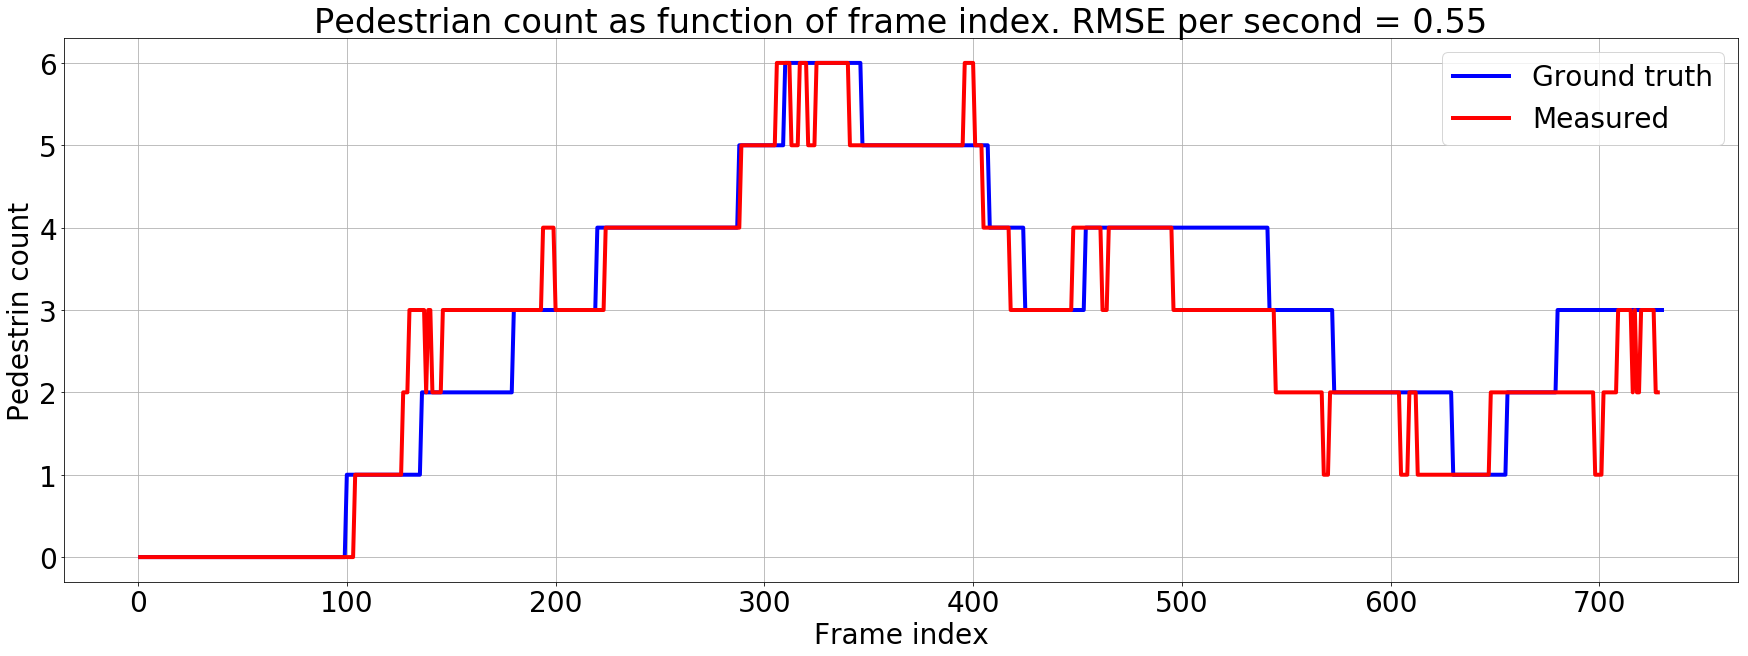

In [137]:
# Calc Root Mean Square Error PER SECOND (seems kind of a reasonable metric)
m = p_cnt_meas.shape[1]     # Num of frames
fps = 24                    # Frames per second
se = (p_cnt_meas-p_cnt_label)**2
se = se[~np.isnan(se)]
RMSE = fps/m*np.sqrt(np.sum(se))

ax = plt.figure(figsize=(30,10))
x = np.array(list(range(1,731)), ndmin=2)
plt.rcParams.update({'font.size': 28})
plt.plot(x[0,:],p_cnt_label[0,:], 'b', linewidth=4)
plt.plot(x[0,:],p_cnt_meas[0,:], 'r', linewidth=4)
plt.grid(b=True, which='both', axis='both')
plt.xlabel('Frame index')
plt.ylabel('Pedestrin count')
plt.legend(['Ground truth','Measured'])
plt.title('Pedestrian count as function of frame index. RMSE per second = %2.2f' % (RMSE))